In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from transformers import AdamW
import pandas as pd
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import csv
import re
import validators
import emoji
import unidecode
import nltk
import pickle
nltk.download('stopwords')

C:\Users\admin\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
# Set the seed for reproducibility
SEED = 1237
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# BERT Hyperparameters (ADDITION)
n_bert_layers = 24  # Assuming the base model has 12 layers
bert_lr = 0.001
pooling_strategy = 'cls'  # Options: 'cls', 'mean', 'max'
bert_hidden_size = 768  # Adjust based on your BERT model
max_seq_length = 128
fine_tune_strategy = 'full'  # Options: 'full', 'last_layer'
bert_dropout = 0.9  # Adjust based on BERT model specifications

max_seq_length = 128  # This should match the max_seq_length used in BERT model
padding_strategy = 'max_length'  # Options: 'max_length', 'do_not_pad', 'longest'
truncation_strategy = 'longest_first'  # Options: 'longest_first', 'only_first', 'only_second'
do_lower_case = True  # Set to False if using a cased model

config = BertConfig(
    num_hidden_layers=n_bert_layers,
    hidden_size=bert_hidden_size,
    num_attention_heads=24,  # Assuming 12 attention heads
    intermediate_size=4 * bert_hidden_size,  # Default value in BERT
    hidden_dropout_prob=bert_dropout,
    attention_probs_dropout_prob=bert_dropout,
)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          max_length=max_seq_length,
                                          padding=padding_strategy,
                                          truncation=truncation_strategy,
                                          do_lower_case=do_lower_case)
# Load the BERT model with the custom configuration
bert_model = BertModel(config=config)


In [43]:
### used multi-label dataset

In [44]:
data_path = "C:/Users/admin/Downloads/multilabel-dataset.csv" 
data_df = pd.read_csv(data_path)
data_df = data_df.rename(columns={'Tweet Content': 'text', 'Sentiment': 'sentiment'})

In [45]:
data_df.head()

text sentiment Label
0  Dictator's son on the cusp of power in the #Ph...  Negative  Hate
1  Kung ang definition ni BongBong Marcos sa isan...  Negative  Hate
2  Leni Robredo is not being subjected by her opp...  Negative  Hate
3  @imstillsour Tuwang tuwa sila sa Pink hahaha.....  Negative  Hate
4  Kapag hindi si VP Leni Robredo ang iboboto mo ...  Negative  Hate

In [51]:
groupedby_sentiment = data_df.groupby(data_df.sentiment)
data_df_positive = groupedby_sentiment.get_group("Positive")
data_df_positive

text sentiment     Label
2560  Nakita nyo naman kung gaano ka tuwid at kungkr...  Positive  Non-hate
2561  Bakit si Leni Robredo?\n\n#LeniKiko2022\n#Rosa...  Positive  Non-hate
2562  Thank you Sir Norberto Gonzales. https://t.co/...  Positive  Non-hate
2563  Tara na at ipakita ang ating buong pagsuporta ...  Positive  Non-hate
2564  “the best man for the job is a woman.” -Leni R...  Positive  Non-hate
...                                                 ...       ...       ...
5115  "Sa Gobyernong Tapat, Angat Buhay Lahat!"\n\nA...  Positive  Non-hate
5116  Leni robredo is the one who stand up while tho...  Positive  Non-hate
5117  OHEMGEEEE WAAAAAAA MADAM PRESIDENT LENI ROBRED...  Positive  Non-hate
5118  Nakakapagod pero President Leni Robredo and Vi...  Positive  Non-hate
5119  It personally meant a lot to me when VP Leni R...  Positive  Non-hate

[2560 rows x 3 columns]

In [52]:
data_df_negative = groupedby_sentiment.get_group("Negative")
data_df_negative

text sentiment Label
0     Dictator's son on the cusp of power in the #Ph...  Negative  Hate
1     Kung ang definition ni BongBong Marcos sa isan...  Negative  Hate
2     Leni Robredo is not being subjected by her opp...  Negative  Hate
3     @imstillsour Tuwang tuwa sila sa Pink hahaha.....  Negative  Hate
4     Kapag hindi si VP Leni Robredo ang iboboto mo ...  Negative  Hate
...                                                 ...       ...   ...
2555  When national leaders are misogynists, female ...  Negative  Hate
2556                            Boo kay leody de guzman  Negative  Hate
2557                    bongbong marcos dot com #ashsgs  Negative  Hate
2558  Why color Pink instead of yellow? \n\n"Yellow ...  Negative  Hate
2559  🤣🤣🤣 Hoy @IskoMoreno, feeling mo si Leni Robred...  Negative  Hate

[2560 rows x 3 columns]

In [53]:
data_df_neutral = groupedby_sentiment.get_group("Neutral")
data_df_neutral

text sentiment     Label
5120  "Ang tatanglaw sa buong bayan ay ang ilaw ng t...   Neutral  Non-hate
5121  "Bongbong Marcos will never sleep with the ene...   Neutral  Non-hate
5122  Plsss READ THIS A GEN Z BOY write a letter for...   Neutral  Non-hate
5123  Bakit alam ni Norberto Gonzales na nag viral s...   Neutral  Non-hate
5124  i will never regret that i volunteered for u, ...   Neutral  Non-hate
...                                                 ...       ...       ...
7675   VP LENI ROBREDO FOR 2022 https://t.co/2ahSefgmST   Neutral  Non-hate
7676  @alt_ego143 @rapplerdotcom @ramboreports hindi...   Neutral  Non-hate
7677  I can't vote yet, but my president is Leni Rob...   Neutral  Non-hate
7678  Anyways President Leni Robredo #SaveLegendsOfT...   Neutral  Non-hate
7679  Kung ayaw nyo d wag nyo iboto.Napaka simple.. ...   Neutral  Non-hate

[2560 rows x 3 columns]

In [54]:
## binary hate non-hate
data_df_positive = data_df_positive.sample(n = 1721)
data_df_neutral = data_df_neutral.sample(n = 1737)
data_df_negative = data_df_negative.sample(n = 1711)

#data_df_nonhate = data_df_positive.append(data_df_neutral)

#data_df = data_df_hate.append(data_df_nonhate)

In [55]:
##data_df = data_df.drop(['Label'], axis = 1)

In [56]:
#data_df.to_csv('dataset.csv', index=False)
data_df

text sentiment     Label
0     Dictator's son on the cusp of power in the #Ph...  Negative      Hate
1     Kung ang definition ni BongBong Marcos sa isan...  Negative      Hate
2     Leni Robredo is not being subjected by her opp...  Negative      Hate
3     @imstillsour Tuwang tuwa sila sa Pink hahaha.....  Negative      Hate
4     Kapag hindi si VP Leni Robredo ang iboboto mo ...  Negative      Hate
...                                                 ...       ...       ...
7675   VP LENI ROBREDO FOR 2022 https://t.co/2ahSefgmST   Neutral  Non-hate
7676  @alt_ego143 @rapplerdotcom @ramboreports hindi...   Neutral  Non-hate
7677  I can't vote yet, but my president is Leni Rob...   Neutral  Non-hate
7678  Anyways President Leni Robredo #SaveLegendsOfT...   Neutral  Non-hate
7679  Kung ayaw nyo d wag nyo iboto.Napaka simple.. ...   Neutral  Non-hate

[7680 rows x 3 columns]

In [57]:
##data_df = data_df.reset_index()

In [58]:
##data_df

In [59]:
# data_df = "dataset.csv"

In [60]:
# Preprocessing function
def preprocess_text(text):
    tokens = tokenizer.tokenize(text)
    tokens = tokens[:tokenizer.model_max_length - 2]  # Account for [CLS] and [SEP] tokens
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokens)
    return indexed_tokens

filipino_stopwords = set(
    """
akin
aking
ako
alin
am
amin
aming
ang
ano
anumang
apat
at
atin
ating
ay
bababa
bago
bakit
bawat
bilang
dahil
dalawa
dapat
din
dito
doon
gagawin
gayunman
ginagawa
ginawa
ginawang
gumawa
gusto
habang
hanggang
hindi
huwag
iba
ibaba
ibabaw
ibig
ikaw
ilagay
ilalim
ilan
inyong
isa
isang
itaas
ito
iyo
iyon
iyong
ka
kahit
kailangan
kailanman
kami
kanila
kanilang
kanino
kanya
kanyang
kapag
kapwa
karamihan
katiyakan
katulad
kaya
kaysa
ko
kong
kulang
kumuha
kung
laban
lahat
lamang
likod
lima
maaari
maaaring
maging
mahusay
makita
marami
marapat
masyado
may
mayroon
mga
minsan
mismo
mula
muli
na
nabanggit
naging
nagkaroon
nais
nakita
namin
napaka
narito
nasaan
ng
ngayon
ni
nila
nilang
nito
niya
niyang
noon
o
pa
paano
pababa
paggawa
pagitan
pagkakaroon
pagkatapos
palabas
pamamagitan
panahon
pangalawa
para
paraan
pareho
pataas
pero
pumunta
pumupunta
sa
saan
sabi
sabihin
sarili
sila
sino
siya
tatlo
tayo
tulad
tungkol
una
walang
""".split()
)

# Date De-Identification
def remove_mentions(text):
    mention_pattern = re.compile(r'@\w+')
    
     # Use re.sub to replace mentions with a single space
    text = mention_pattern.sub(' ', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(text.split())
    
    return cleaned_text

# URL Removal
def remove_url (text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    
    # Use re.sub to replace URLs with a single space
    text = url_pattern.sub(' ', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(text.split())
    
    return cleaned_text

# Special Characters Removal
def remove_special_characters(text):
    # Remove emojis
    text = emoji.replace_emoji(text, replace="[emoji]")
    
    # Split the text into words
    words = text.split(" ")
    
    # Initialize an empty string to store the cleaned text
    cleaned_text = ""
    
    # Iterate through each word
    for word in words:
        # Check if the word contains only special characters or "[emoji]"
        if not (re.match(r"^[_\W]+$", word) or "[emoji]" in word):
            if len(cleaned_text) == 0:
                cleaned_text = f"{word}"
            else:
                cleaned_text = f"{cleaned_text} {word}"
    
    return cleaned_text

# Numerics Removal and Further Special Characters Removal
def remove_numerics(text):
    # Remove diacritics
    text_no_diacritics = unidecode.unidecode(text)

    # Split the text into words
    sentence = text_no_diacritics.split(" ")
    output = ""

    # Remove special characters and numerics
    for part in sentence:
        part = re.sub("[^A-Za-z ]+$", "", part)
        part = re.sub("^[^A-Za-z #]+", "", part)
        if not (len(part) <= 1 or re.match(r"[^a-zA-Z#]", part)):
            if len(output) == 0:
                output = f"{part}"
            else:
                output = f"{output} {part}"

    return output

# Remove English Stop Words
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

def remove_english_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Remove Filipino Stop Words
def remove_filipino_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in filipino_stopwords]
    return ' '.join(filtered_words)

# Candidate Name Removal
def remove_candidate_names(text):
    candidatelist = "leni robredo bongbong marcos isko moreno domagoso manny pacman pacquiao ping lacson ernie abella leody de guzman norberto gonzales jose montemayor jr faisal mangondato"
    candidatelist = candidatelist.split()
    candidate_pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, candidatelist)) + r')\b', re.IGNORECASE)
    
    # Use re.sub to replace candidate names with a single space
    text = candidate_pattern.sub(' ', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(text.split())
    
    return cleaned_text

# Hashtag Removal
def remove_hashtags(text):
    # Use regular expression to remove hashtags and the associated word
    cleaned_text = re.sub(r'#\w+', '', text)
    
    return cleaned_text

In [61]:
#PreProcessing

# Data De-Identification
data_df['text'] = data_df['text'].apply(remove_mentions)

# URL Removal
data_df['text'] = data_df['text'].apply(remove_url)

# Special Characters Removal
data_df['text'] = data_df['text'].apply(remove_special_characters)

# Lowercase
data_df['text'] = data_df['text'].str.lower()

# Remove Numerics
data_df['text'] = data_df['text'].apply(remove_numerics)

# Remove English Stop Words
#data_df['text'] = data_df['text'].apply(remove_english_stopwords)

# Remove Filipino Stop Words
#data_df['text'] = data_df['text'].apply(remove_filipino_stopwords)

# Remove Candidate Names
data_df['text'] = data_df['text'].apply(remove_candidate_names)

# Remove Hashtags
data_df['text'] = data_df['text'].apply(remove_hashtags)
data_df['text'] = data_df['text'].str.replace(r'[^a-zA-Z0-9\s!?]', '', regex=True)
data_df['text'] = data_df['text'].str.replace(r'[^A-Za-z\s#]', '', regex=True)

data_df.to_csv('sample7.csv', index=False)

#data_df['text'] = data_df['text'].apply(preprocess_text)

In [62]:
# Initialize counters for each sentiment label
sentiment_counter = {
    'Positive': 0,
    'Negative': 0,
    'Neutral': 0
}

# Check for empty strings or whitespace in the 'text' column
empty_text_rows = data_df[data_df['text'].str.strip().eq("")]
for index, row in empty_text_rows.iterrows():
    print(f"Empty string found in row {index} with sentiment label: {row['sentiment']}")
    sentiment_counter[row['sentiment']] += 1

# Remove rows with empty strings or whitespace in the 'text' column
data_df.drop(data_df[data_df['text'].str.strip().eq("")].index, inplace=True)
print(f"{len(empty_text_rows)} rows with empty 'text' values have been removed.")

# Update the sentiment counters for the remaining rows
for sentiment in data_df['sentiment']:
    sentiment_counter[sentiment] += 1

# If you want to save the modified DataFrame back to a CSV file, you can use the following line:
# data_df.to_csv('path_to_save_modified_file.csv', index=False)  # Replace 'path_to_save_modified_file.csv' with your desired path

# Display the modified DataFrame
data_df.head()

# Display the sentiment counters
print("Sentiment Counters:")
for sentiment, count in sentiment_counter.items():
    print(f"{sentiment}: {count}")

Empty string found in row 1093 with sentiment label: Negative
Empty string found in row 1322 with sentiment label: Negative
Empty string found in row 1367 with sentiment label: Negative
Empty string found in row 1797 with sentiment label: Negative
Empty string found in row 3134 with sentiment label: Positive
Empty string found in row 3408 with sentiment label: Positive
Empty string found in row 3588 with sentiment label: Positive
Empty string found in row 3622 with sentiment label: Positive
Empty string found in row 3965 with sentiment label: Positive
Empty string found in row 4060 with sentiment label: Positive
Empty string found in row 4179 with sentiment label: Positive
Empty string found in row 4774 with sentiment label: Positive
Empty string found in row 4866 with sentiment label: Positive
Empty string found in row 4905 with sentiment label: Positive
Empty string found in row 4956 with sentiment label: Positive
Empty string found in row 4987 with sentiment label: Positive
Empty st

In [63]:
data_df

text sentiment     Label
0           dictators son on the cusp of power in the    Negative      Hate
1     kung ang definition ni sa isang terorista ay i...  Negative      Hate
2     is not being subjected by her opponents to gen...  Negative      Hate
3     tuwang tuwa sila sa pink hahahahindi nila alam...  Negative      Hate
4     kapag hindi si vp ang iboboto mo sa may years ...  Negative      Hate
...                                                 ...       ...       ...
7675                                             vp for   Neutral  Non-hate
7676  hindi pangngumbinse ang tawag dyan what he is ...   Neutral  Non-hate
7677  cant vote yet but my president is and my vice ...   Neutral  Non-hate
7678                                 anyways president    Neutral  Non-hate
7679  kung ayaw nyo wag nyo ibotonapaka simple basta...   Neutral  Non-hate

[7632 rows x 3 columns]

In [64]:
data_df['text'] = data_df['text'].apply(preprocess_text)

In [65]:
data_df

text sentiment     Label
0     [21237, 2015, 2365, 2006, 1996, 12731, 13102, ...  Negative      Hate
1     [18577, 17076, 6210, 9152, 7842, 18061, 3070, ...  Negative      Hate
2     [2003, 2025, 2108, 13532, 2011, 2014, 7892, 20...  Negative      Hate
3     [10722, 16600, 10722, 4213, 9033, 2721, 7842, ...  Negative      Hate
4     [10556, 4502, 2290, 9269, 9033, 21210, 17076, ...  Negative      Hate
...                                                 ...       ...       ...
7675                                      [21210, 2005]   Neutral  Non-hate
7676  [9269, 20657, 3070, 25438, 7076, 2063, 17076, ...   Neutral  Non-hate
7677  [2064, 2102, 3789, 2664, 2021, 2026, 2343, 200...   Neutral  Non-hate
7678                                 [4312, 2015, 2343]   Neutral  Non-hate
7679  [18577, 1037, 3148, 2860, 6396, 2080, 11333, 2...   Neutral  Non-hate

[7632 rows x 3 columns]

In [66]:
data_df = data_df.reset_index()
data_df

index                                               text sentiment  \
0         0  [21237, 2015, 2365, 2006, 1996, 12731, 13102, ...  Negative   
1         1  [18577, 17076, 6210, 9152, 7842, 18061, 3070, ...  Negative   
2         2  [2003, 2025, 2108, 13532, 2011, 2014, 7892, 20...  Negative   
3         3  [10722, 16600, 10722, 4213, 9033, 2721, 7842, ...  Negative   
4         4  [10556, 4502, 2290, 9269, 9033, 21210, 17076, ...  Negative   
...     ...                                                ...       ...   
7627   7675                                      [21210, 2005]   Neutral   
7628   7676  [9269, 20657, 3070, 25438, 7076, 2063, 17076, ...   Neutral   
7629   7677  [2064, 2102, 3789, 2664, 2021, 2026, 2343, 200...   Neutral   
7630   7678                                 [4312, 2015, 2343]   Neutral   
7631   7679  [18577, 1037, 3148, 2860, 6396, 2080, 11333, 2...   Neutral   

         Label  
0         Hate  
1         Hate  
2         Hate  
3         Hate  
4         Hate  
...        ...  
7627  Non-hate  
7628  Non-hate  
7629  Non-hate  
7630  Non-hate  
7631  Non-hate  

[7632 rows x 4 columns]

In [67]:
train_df, test_df = train_test_split(data_df, test_size=0.3, random_state=SEED)

In [68]:
### changed output_dim=3, added torch.softmax

In [69]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_dropout = nn.Dropout(dropout) 
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=256, kernel_size=2, padding='same')
        self.pool1 = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=64, kernel_size=4, padding='same')
        self.global_pooling = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        x = embedded.permute(0, 2, 1)  # Change the dimensions for convolution
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.global_pooling(x).squeeze(2)
        x = self.dropout(x)
        x = self.fc(x)
        x = torch.softmax(x, dim=1)
        
        return x

In [70]:
# Set up iterators
BATCH_SIZE = 64

In [71]:
### changed "label" to "sentiment"

In [72]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, max_seq_length):
        self.data = dataframe
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        sentiment = self.data.iloc[idx]['sentiment']

        # Padding and conversion to tensor
        padded_text = torch.tensor(text[:self.max_seq_length] + [0] * (self.max_seq_length - len(text)))
        return padded_text, sentiment

In [73]:
train_dataset = TextDataset(train_df, 1000)
test_dataset = TextDataset(test_df, 1000)

In [1]:
train_iterator = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

NameError: name 'torch' is not defined

In [ ]:
# Define model hyperparameters
VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 768
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
OUTPUT_DIM = 3
DROPOUT = 0.5

# CNN Hyperparameters
hidden_dim = 100
n_conv_layers = 1
kernel_sizes = [2, 3, 4]
activation = nn.ReLU()

In [ ]:
# Initialize CNN model
model = CNN(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)
#Initialize CNN model
# model = CNN(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, hidden_dim, n_conv_layers, kernel_sizes, activation)

In [77]:
# Initialize BERT model (for embedding extraction)
bert_model.eval()  # Set to evaluation mode

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.9, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.9, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.9, inplace=False)
          

In [78]:
with torch.no_grad():
    for i, token in enumerate(tokenizer.get_vocab()):
        token_id = tokenizer.convert_tokens_to_ids(token)
        token_embedding = bert_model.embeddings.word_embeddings.weight[token_id]
        model.embedding.weight[i].data.copy_(token_embedding)

bert_parameters = []
for layer in bert_model.encoder.layer:
    bert_parameters.extend(layer.parameters())

# Create AdamW optimizer with custom hyperparameters for BERT embeddings
bert_learning_rate = 2e-4  # Adjust as needed
bert_optimizer = optim.AdamW(bert_parameters, lr=bert_learning_rate)

In [79]:
data_df

index                                               text sentiment  \
0         0  [21237, 2015, 2365, 2006, 1996, 12731, 13102, ...  Negative   
1         1  [18577, 17076, 6210, 9152, 7842, 18061, 3070, ...  Negative   
2         2  [2003, 2025, 2108, 13532, 2011, 2014, 7892, 20...  Negative   
3         3  [10722, 16600, 10722, 4213, 9033, 2721, 7842, ...  Negative   
4         4  [10556, 4502, 2290, 9269, 9033, 21210, 17076, ...  Negative   
...     ...                                                ...       ...   
7627   7675                                      [21210, 2005]   Neutral   
7628   7676  [9269, 20657, 3070, 25438, 7076, 2063, 17076, ...   Neutral   
7629   7677  [2064, 2102, 3789, 2664, 2021, 2026, 2343, 200...   Neutral   
7630   7678                                 [4312, 2015, 2343]   Neutral   
7631   7679  [18577, 1037, 3148, 2860, 6396, 2080, 11333, 2...   Neutral   

         Label  
0         Hate  
1         Hate  
2         Hate  
3         Hate  
4         Hate  
...        ...  
7627  Non-hate  
7628  Non-hate  
7629  Non-hate  
7630  Non-hate  
7631  Non-hate  

[7632 rows x 4 columns]

In [80]:
### changed nn.BCEWithLogitsLoss to nn.CrossEntropyLoss

In [81]:
#optimizer = optim.Adam(model.parameters())
# Your custom hyperparameters
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-08
weight_decay = 0.0

# Create Adam optimizer with custom hyperparameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=epsilon, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [82]:
### added dictionary
### changed from binary to multilabel in train and eval 
### changed calculation of accuracy, f1, precision, recall 

In [83]:
# Create a dictionary to map class labels to numerical indices
label_to_index = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}

# Train function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, iterator):
    model.train()
    epoch_loss = 0
    for text_batch, sentiment_batch in iterator:
        # Extract text sequences from the text_batch tensor
        texts = text_batch
        
        # BINARY
        ## Extract and process labels
        ## labels = [1 if label == 'Hate' else 0 for label in label_batch]  # Example conversion
        
        # MULTILBAEL
        # Use numerical labels for multi-class classification
        labels = torch.tensor([label_to_index[sentiment] for sentiment in sentiment_batch]).to(device)

        texts = texts.to(device)  # Move to device if needed
        ## labels = torch.tensor(labels, dtype=torch.float32).to(device)  # Convert to tensor
        
        optimizer.zero_grad()
        predictions = model(texts).squeeze(1)
        
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)


# Evaluate function
def evaluate(model, iterator):
    model.eval()
    epoch_loss = 0
    predicted_sentiments = []
    true_sentiments = []  # Declare the true_sentiments list
    
    with torch.no_grad():
        for text_batch, sentiment_batch in iterator:
            texts = text_batch  # Extract text sequences
            
            ## labels = [1 if label == 'Hate' else 0 for label in label_batch]  # Example conversion
            
            # Use numerical labels for multi-class classification
            labels = torch.tensor([label_to_index[sentiment] for sentiment in sentiment_batch]).to(device)
            
            texts = texts.to(device)  # Move to device
            ## labels = torch.tensor(labels, dtype=torch.float32).to(device)  # Convert to tensor
            
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            
            ## predicted_labels.extend(torch.round(torch.sigmoid(predictions)).cpu().numpy())
            ## true_labels.extend(labels.cpu().numpy())
            
            # Convert predictions to class labels
            predicted_sentiments.extend([list(label_to_index.keys())[list(label_to_index.values()).index(idx)] for idx in torch.argmax(predictions, dim=1).cpu().numpy()])
            true_sentiments.extend([list(label_to_index.keys())[list(label_to_index.values()).index(idx)] for idx in labels.cpu().numpy()])
    
    # Calculate accuracy, f1, precision, recall
    
    ##accuracy = accuracy_score(true_labels, predicted_labels)
    ##f1 = f1_score(true_labels, predicted_labels)
    ##precision = precision_score(true_labels, predicted_labels)
    ##recall = recall_score(true_labels, predicted_labels)
    
    # Calculate accuracy, f1, precision, recall
    accuracy = accuracy_score(true_sentiments, predicted_sentiments)
    f1 = f1_score(true_sentiments, predicted_sentiments, average='macro')
    precision = precision_score(true_sentiments, predicted_sentiments, average='macro')
    recall = recall_score(true_sentiments, predicted_sentiments, average='macro')
    
    return epoch_loss / len(iterator), accuracy, f1, precision, recall, predicted_sentiments, true_sentiments

In [84]:
### revised

Epoch: 01

	Train Loss: 1.028
	Test Loss: 0.952

	Accuracy: 0.5655 | F1-Score: 0.5290
	Precision: 0.5306 | Recall: 0.5605

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.6457    0.7928    0.7117       777
    Negative     0.3951    0.1952    0.2613       743
     Neutral     0.5511    0.6935    0.6141       770

    accuracy                         0.5655      2290
   macro avg     0.5306    0.5605    0.5290      2290
weighted avg     0.5326    0.5655    0.5328      2290


[[616 105  56]
 [219 145 379]
 [119 117 534]]


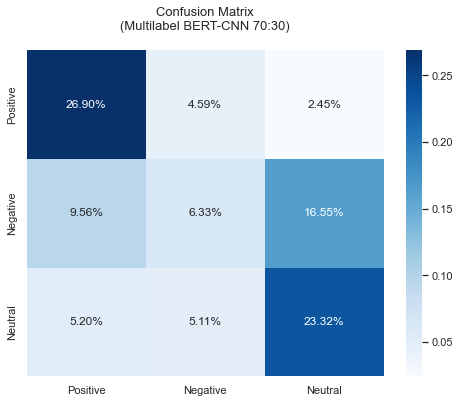

Epoch: 02

	Train Loss: 0.921
	Test Loss: 0.949

	Accuracy: 0.5703 | F1-Score: 0.5578
	Precision: 0.5673 | Recall: 0.5676

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.6225    0.8275    0.7105       777
    Negative     0.4284    0.4024    0.4150       743
     Neutral     0.6512    0.4727    0.5478       770

    accuracy                         0.5703      2290
   macro avg     0.5673    0.5676    0.5578      2290
weighted avg     0.5691    0.5703    0.5599      2290


[[643 119  15]
 [264 299 180]
 [126 280 364]]


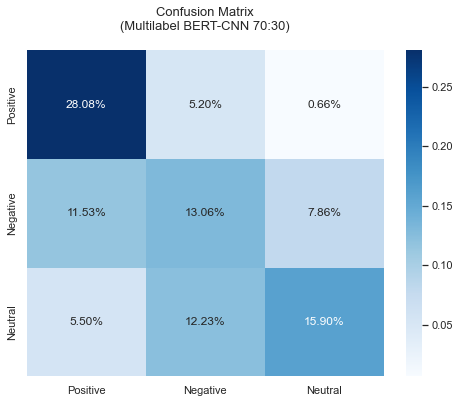

In [86]:
from sklearn.metrics import classification_report

N_EPOCHS = 2
predicted_sentiments_per_epoch = []
true_sentiments_per_epoch = []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_iterator)
    test_loss, accuracy, f1, precision, recall, predicted_sentiments, true_sentiments = evaluate(model, test_iterator)
    
    # Save the predicted_sentiments and true_sentiments for the current epoch
    predicted_sentiments_per_epoch.append(predicted_sentiments)
    true_sentiments_per_epoch.append(true_sentiments)

    # Print other metrics (e.g., accuracy, loss) for the current epoch
    print(f'Epoch: {epoch + 1:02}\n')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tTest Loss: {test_loss:.3f}\n')
    print(f'\tAccuracy: {accuracy:.4f} | F1-Score: {f1:.4f}')
    print(f'\tPrecision: {precision:.4f} | Recall: {recall:.4f}\n')
    print(f'\tClassification Report:\n')
    report = classification_report(true_sentiments, predicted_sentiments, target_names=['Positive', 'Negative', 'Neutral'], digits = 4)
    print(f'{report}\n')
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np  # Import numpy for matrix normalization

    # Calculate the confusion matrix
    cf_matrix = confusion_matrix(true_sentiments, predicted_sentiments)
    print(cf_matrix)

    # Plot the confusion matrix using seaborn
    sns.set(rc={"figure.figsize": (8, 6)})  # Add a closing parenthesis to set
    ax = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'], fmt='.2%', cmap='Blues')

    plt.title('Confusion Matrix\n(Multilabel BERT-CNN 70:30)\n', fontsize=13)
    plt.show()

In [88]:
import tkinter as tk
from tkinter import filedialog
from tkinter import messagebox

# Place your existing code here

# Create a simple GUI
class MultiLabelClassifierGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("MultiLabel Classifier")

        self.label = tk.Label(self.root, text="Upload Text File")
        self.label.pack()

        self.upload_button = tk.Button(self.root, text="Upload", command=self.upload_file)
        self.upload_button.pack()

    def upload_file(self):
        file_path = filedialog.askopenfilename()
        if file_path:
            messagebox.showinfo("File Selected", f"Selected file: {file_path}")
            # You can add your dataset processing and model prediction here

if __name__ == "__main__":
    root = tk.Tk()
    app = MultiLabelClassifierGUI(root)
    root.mainloop()

KeyboardInterrupt: 